# Scientific Computing: Assignment Set 1
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from importlib import reload

The following code is used to clone the repository in case of using in Google Colab.

In [ ]:
# !git clone https://github.com/mboyan/scientific-computing
# %ls

The code below loads some custom modules.

In [68]:
import pde_simulations as pde
import vis_tools as vt

## 1. The 1D Wave Equation

The one-dimensional wave equation can be used to represent the vibrations of a uniform string and takes the form:

$$
\frac{\partial^2\Psi}{\partial t^2}=c^2\frac{\partial^2\Psi}{\partial x^2}.\tag{1}
$$

This equation describes the relationship between the second derivative of the vibration amplitude $\Psi$ with respect to time and the second derivative of the amplitude with respect to a position along the string. The multiplicative factor $c$ is a characteristic physical constant describing the material properties. The variable of interest is $\Psi(x, t)$, which represents the amplitude of the string's vibration as defined by the displacement of a position on the string as a function of time.

### 1.1. Discretising the Equation

In order to obtain numerical solution $\Psi(x, t)$, the equation needs to be discretised through the means of Finite Differencing. In the case of second-order derivatives, this allows expressing the temporal and the spatial terms as

$$
\frac{\partial^2\Psi}{\partial t^2}\equiv\frac{u_{i,j+1}+u_{i,j-1}-2u_{i,j}}{\Delta{t}^2}
$$

and

$$
\frac{\partial^2\Psi}{\partial x^2}\equiv\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\Delta{x}^2},
$$

respectively, with $u_{i,j}$ being the discrete equivalent of $\Psi(x, t)$ in the spatial ($i\equiv x$) and temporal ($j\equiv t$) domain. Substituting the corresponding terms in (1) yields the following equation:

$$
\frac{u_{i,j+1}+u_{i,j-1}-2u_{i,j}}{\Delta{t}^2} = c^2 \left[\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\Delta{x}^2}\right].
$$

Rewriting it, one can obtain the time-iteration function:

$$
u_{i,j+1}=c^2\Delta{t}^2\left[\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\Delta{x}^2}\right] - u_{i, j-1} + 2u_{i,j}.
$$

Therefore, at any update, the amplitude at the current position is taken into account for the previous timestep, along with the amplitude at the current position and its neighbours for the current timestep.

### 1.2. Boundary and Initial Conditions

The length $L$ of the string is normalised to unity for convenience. A spatial discretisation is performed with $N=1000$ subdivisions, resulting in $\Delta{x}=10^{-3}$. For the numerical experiment it is assumed that the boundaries of the string are fixed, meaning that:

$$
\Psi(x=0,t)=\Psi(x=1,t)=0.
$$

The experiment assumes a constant $c$ is set to $1$ and a timestep $\Delta{t}=0.001$. Three different initial conditions are explored:

1) $\Psi(x,t=0)=sin(2\pi x)$;
2) $\Psi(x,t=0)=sin(5\pi x)$;
3) $\Psi(x,t=0)=sin(5\pi x)$ if $1/5<x<2/5$, else $\Psi=0$.

It is assumed that at time $t=0$ the string is at rest, meaning that the derivative $\Psi'(x,t)$ is zero. This implies that the initial condition also extends to time $t=-1$.

The simulations are run for 100 iterations.

In [76]:
reload(pde)
reload(vt)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 1\\vis_tools.py'>

In [35]:
# Simulation parameters
t_max = 900
N = 1000

# Initial conditions
x_samples = np.linspace(0, 1, N)
init_cond = np.empty((4, N))
init_cond[0] = np.sin(2*np.pi*x_samples)
init_cond[1] = np.sin(5*np.pi*x_samples)
init_cond[2] = np.where((x_samples > 0.2) & (x_samples < 0.4), init_cond[1], 0)
init_cond[3] = np.where(x_samples < 0.25, x_samples*4, 1 - (4*x_samples-1)/3)

# Run simulations
u_evolutions = np.empty((init_cond.shape[0], t_max, init_cond.shape[1]))
for i in range(init_cond.shape[0]):
    u_evolutions[i] = pde.vibrating_string(init_cond[i], t_max)

Next, the results of the simulations are plotted.

[]

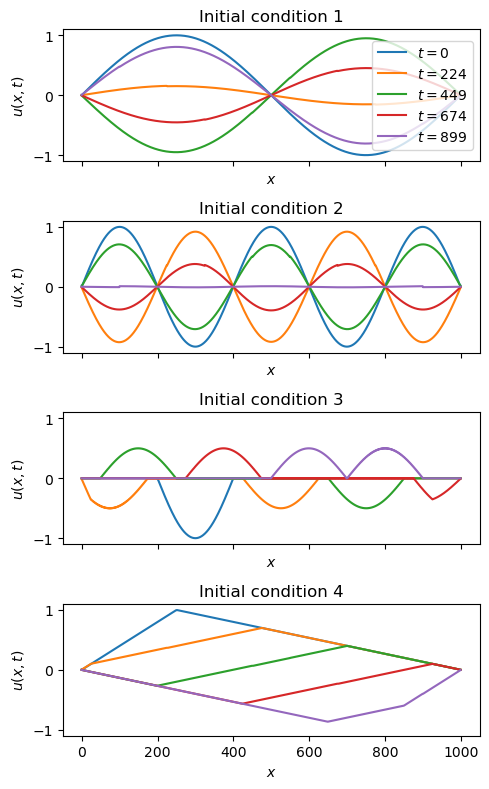

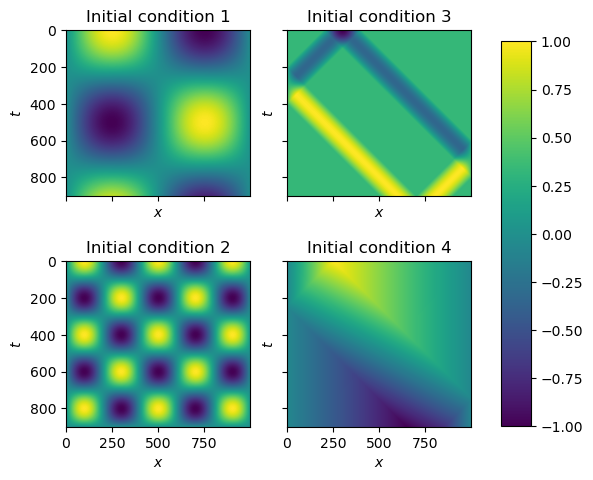

In [67]:
# Determine moments to plot
n_frames = 5
t_plot = np.linspace(0, t_max-1, n_frames, dtype=int)

fig, axs = plt.subplots(init_cond.shape[0], 1, sharex=True, sharey=True)
fig.set_size_inches(5, 8)

# Plot amplitudes for different moments in time
for i, u in enumerate(u_evolutions):
    for t in t_plot:
        axs[i].plot(u[t], label=f'$t={t}$')
    axs[i].set_xlabel('$x$')
    axs[i].set_ylabel('$u(x,t)$')
    axs[i].set_title(f'Initial condition {i+1}')
    if i == 0: axs[i].legend()

plt.tight_layout()
plt.plot()

# Plot amplitude evolutions
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 5.5)
im = []

for i, u in enumerate(u_evolutions):
    im.append(axs[i%2, int(np.floor(i/2))].imshow(u))
    axs[i%2, int(np.floor(i/2))].set_xlabel('$x$')
    axs[i%2, int(np.floor(i/2))].set_ylabel('$t$')
    axs[i%2, int(np.floor(i/2))].set_title(f'Initial condition {i+1}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.135, 0.05, 0.7])
fig.colorbar(im[0], cax=cbar_ax)

# plt.tight_layout()
plt.plot()

The following animations illustrate the amplitude changes caused by each initial condition.

In [80]:
reload(vt)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 1\\vis_tools.py'>

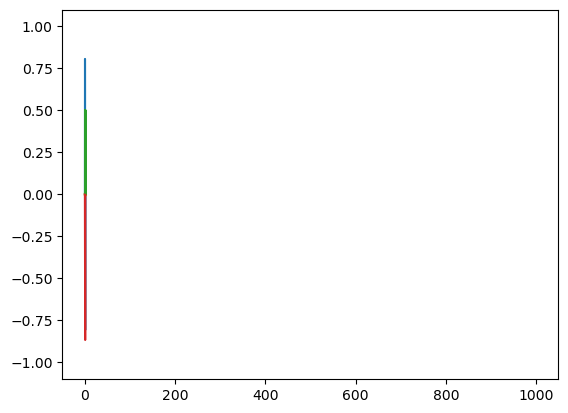

In [81]:
for i, u in enumerate(u_evolutions):
    vt.animate_frames(u)